In [ ]:
import re
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from datetime import timedelta



### Weather / Rain Data

In [46]:
df = pd.read_csv('../data/noaa_weather_data.csv')
df = df[df['STATION'] == "USW00093197"]
df['DATE'] = pd.to_datetime(df["DATE"])
filtered = df[df['PRCP'] > 0.0]
rain_dates = filtered['DATE'].unique()
rain_dates = pd.to_datetime(rain_dates)
rain_dates


<DatetimeArray>
['2025-01-25 00:00:00', '2025-01-26 00:00:00', '2025-01-27 00:00:00',
 '2025-02-04 00:00:00', '2025-02-05 00:00:00', '2025-02-06 00:00:00',
 '2025-02-07 00:00:00', '2025-02-12 00:00:00', '2025-02-13 00:00:00',
 '2025-02-14 00:00:00', '2025-03-05 00:00:00', '2025-03-06 00:00:00',
 '2025-03-11 00:00:00', '2025-03-12 00:00:00', '2025-03-13 00:00:00',
 '2025-03-14 00:00:00', '2025-03-17 00:00:00', '2025-03-26 00:00:00',
 '2025-03-30 00:00:00', '2025-03-31 00:00:00', '2025-04-26 00:00:00']
Length: 21, dtype: datetime64[ns]

In [49]:
# Identify consecutive rainy days
rain_blocks = []
start_date = rain_dates[0]
end_date = start_date

for current_date in rain_dates[1:]:
    if current_date - end_date == timedelta(days=1):
        # Continue the current block
        end_date = current_date
    else:
        # Save the previous block and start a new one
        rain_blocks.append((start_date, end_date))
        start_date = end_date = current_date

# Add the last block
rain_blocks.append((start_date, end_date))
rain_blocks

[(Timestamp('2025-01-25 00:00:00'), Timestamp('2025-01-27 00:00:00')),
 (Timestamp('2025-02-04 00:00:00'), Timestamp('2025-02-07 00:00:00')),
 (Timestamp('2025-02-12 00:00:00'), Timestamp('2025-02-14 00:00:00')),
 (Timestamp('2025-03-05 00:00:00'), Timestamp('2025-03-06 00:00:00')),
 (Timestamp('2025-03-11 00:00:00'), Timestamp('2025-03-14 00:00:00')),
 (Timestamp('2025-03-17 00:00:00'), Timestamp('2025-03-17 00:00:00')),
 (Timestamp('2025-03-26 00:00:00'), Timestamp('2025-03-26 00:00:00')),
 (Timestamp('2025-03-30 00:00:00'), Timestamp('2025-03-31 00:00:00')),
 (Timestamp('2025-04-26 00:00:00'), Timestamp('2025-04-26 00:00:00'))]

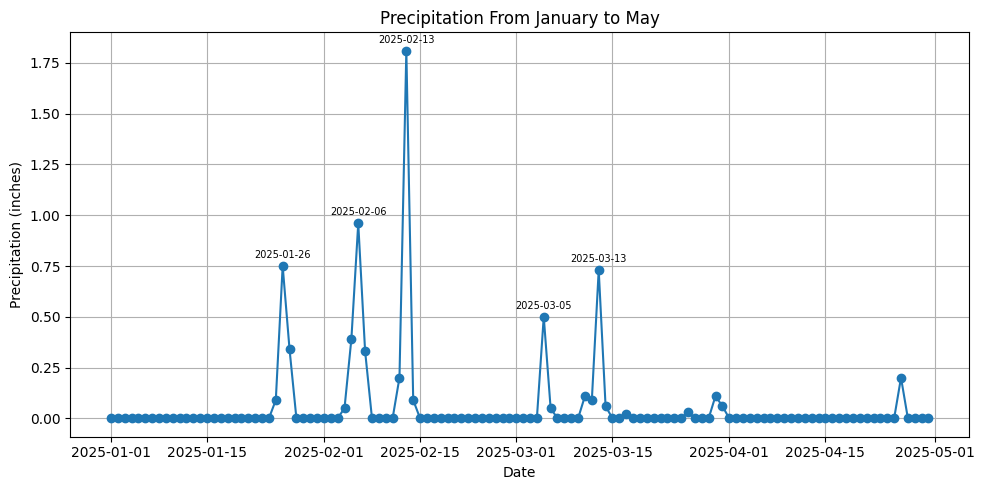

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(df['DATE'], df['PRCP'], marker='o') 

# Annotate dates where precipitation is not zero
for i, row in df.iterrows():
    if row['PRCP'] >= 0.5:
        date_str = row['DATE'].strftime('%Y-%m-%d')
        plt.text(row['DATE'], row['PRCP'] + 0.03, date_str,
                 ha='center', va='bottom', fontsize=7)

plt.title('Precipitation From January to May')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# The local maximum precipitation dates
key_rain_dates = ["2025-01-26", "2025-02-06", "2025-02-13", "2025-03-05", "2025-03-13", "2025-03-30", "2025-04-26"]


In [2]:
def extract_time_from_filename(filename):
    # Example: '...20240509T1230Z.nc' → datetime object
    match = re.search(r'(\d{8}T\d{4})', filename)
    if match:
        return datetime.strptime(match.group(1), '%Y%m%dT%H%M')
    else:
        raise ValueError(f"Timestamp not found in {filename}")

def load_merged_dataset(data_dir, variables_of_interest) -> 'xr.Dataset':
    """
    Loads .nc files from a data directory for an instrument and area of interest
    and extracts the coordinates and variables of interest. Merges all the data together
    with a new time coordinate and returns an xarray dataset.
    """
    datasets = []
    for file_path in data_dir.iterdir():
        try:
            # Open data variables from geophysical group
            ds_data = xr.open_dataset(file_path, group="geophysical_data")
            selected_vars = ds_data[variables_of_interest]

            # Open coordinates from navigation group
            ds_nav = xr.open_dataset(file_path, group="navigation_data")
            ds_nav = ds_nav.set_coords(("longitude", "latitude"))

            # Merge variables with coordinates
            merged = xr.merge([selected_vars, ds_nav.coords])

            time_value = extract_time_from_filename(file_path.stem)
            merged = merged.expand_dims(time=[time_value])

            datasets.append(merged)

        except Exception as e:
            print(f"Skipping file {file_path.name}: {e}")
            continue

    min_lines = min(ds.sizes['number_of_lines'] for ds in datasets)

    datasets_trimmed = [
        ds.isel(number_of_lines=slice(0, min_lines)) for ds in datasets
    ]

    # Concatenate along the time dimension
    combined = xr.concat(datasets_trimmed, dim="time")
    return combined

In [3]:
aop_dir = Path("../data/PACE_OCI_L2_AOP_NRT")
bgc_dir = Path("../data/PACE_OCI_L2_BGC_NRT")
landvi_dir = Path("../data/PACE_OCI_L2_LANDVI_NRT")
modisa_dir = Path("../data/MODISA_L2_OC")

pacific_pal_bbox = (-118.75, 33.90, -118.45, 34.15)

In [4]:
modisa_merged_ds = load_merged_dataset(modisa_dir, ["chlor_a"])
modisa_merged_ds

Skipping file AQUA_MODIS.20241222T215501.L2.OC.nc: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
Skipping file AQUA_MODIS.20241223T223500.L2.OC.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\MODISA_L2_OC\\AQUA_MODIS.20241223T223500.L2.OC.nc'
Skipping file AQUA_MODIS.20241224T213501.L2.OC.nc: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://

<xarray.Dataset> Size: 4GB
Dimensions:    (time: 128, number_of_lines: 2030, pixels_per_line: 1354)
Coordinates:
  * time       (time) datetime64[ns] 1kB 2024-12-29T21:40:00 ... 2025-05-01T2...
    longitude  (time, number_of_lines, pixels_per_line) float32 1GB -101.7 .....
    latitude   (time, number_of_lines, pixels_per_line) float32 1GB 36.0 ... ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    chlor_a    (time, number_of_lines, pixels_per_line) float32 1GB nan ... nan

In [5]:
def summarize_variables_in_bbox(ds, variable_names, bbox):
    lon_min, lat_min, lon_max, lat_max = bbox
    times = ds['time'].values
    summaries = {var: [] for var in variable_names}

    for t in range(len(times)):
        lat = ds['latitude'].isel(time=t).values
        lon = ds['longitude'].isel(time=t).values

        # Create bounding box mask
        mask = (
            (lon >= lon_min) & (lon <= lon_max) &
            (lat >= lat_min) & (lat <= lat_max)
        )

        for var in variable_names:
            var_slice = ds[var].isel(time=t).values
            data_vals = var_slice[mask]

            valid_pixels = np.count_nonzero(~np.isnan(data_vals))
            nan_pixels = np.count_nonzero(np.isnan(data_vals))
            mean_val = np.nanmean(data_vals) if valid_pixels > 0 else np.nan

            summaries[var].append({
                "time": times[t],
                "mean_value": mean_val,
                "valid_pixels": valid_pixels,
                "nan_pixels": nan_pixels
            })

    return summaries

modisa_summary = summarize_variables_in_bbox(modisa_merged_ds, ["chlor_a"], pacific_pal_bbox)
modisa_summary

{'chlor_a': [{'time': np.datetime64('2024-12-29T21:40:00.000000000'),
   'mean_value': nan,
   'valid_pixels': 0,
   'nan_pixels': 18},
  {'time': np.datetime64('2024-12-30T22:15:00.000000000'),
   'mean_value': np.float32(0.25492695),
   'valid_pixels': 96,
   'nan_pixels': 384},
  {'time': np.datetime64('2024-12-31T21:20:00.000000000'),
   'mean_value': nan,
   'valid_pixels': 0,
   'nan_pixels': 269},
  {'time': np.datetime64('2025-01-01T22:00:00.000000000'),
   'mean_value': np.float32(2.8025482),
   'valid_pixels': 279,
   'nan_pixels': 486},
  {'time': np.datetime64('2025-01-02T22:35:00.000000000'),
   'mean_value': np.float32(2.0273936),
   'valid_pixels': 78,
   'nan_pixels': 157},
  {'time': np.datetime64('2025-01-03T21:40:00.000000000'),
   'mean_value': np.float32(4.64773),
   'valid_pixels': 161,
   'nan_pixels': 391},
  {'time': np.datetime64('2025-01-04T22:20:00.000000000'),
   'mean_value': nan,
   'valid_pixels': 0,
   'nan_pixels': 465},
  {'time': np.datetime64('2025-

In [6]:
def plot_pixel_counts(summary_dict, start_date=None, end_date=None, title=None):
    """
    Plots valid pixel and NaN pixel counts over time for each variable.
    
    Parameters:
    -----------
    summary_dict : dict
        Dictionary of format:
        {
            'variable_name': [
                {'time': np.datetime64, 'mean_value': float, 'valid_pixels': int, 'nan_pixels': int},
                ...
            ],
            ...
        }
    start_date : str or datetime, optional
        Earliest date to include (e.g., '2025-01-05')
    end_date : str or datetime, optional
        Latest date to include (e.g., '2025-01-20')
    """
    for var_name, summaries in summary_dict.items():
        # Convert list of dicts to DataFrame
        df = pd.DataFrame(summaries)
        df['time'] = pd.to_datetime(df['time'])

        # Filter by date range if specified
        if start_date:
            df = df[df['time'] >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df['time'] <= pd.to_datetime(end_date)]

        if df.empty:
            print(f"No data available for '{var_name}' in the specified date range.")
            continue

        # Create plot
        fig, ax1 = plt.subplots(figsize=(12, 6))
        bar_width = 0.3
        x = np.arange(len(df))

        ax1.bar(x - bar_width, df['valid_pixels'], width=bar_width, label='Valid Pixels', color='green')
        ax1.bar(x, df['nan_pixels'], width=bar_width, label='NaN Pixels', color='red')
        ax1.set_ylabel('Pixel Count')
        ax1.set_xlabel('Time')
        ax1.set_xticks(x)
        ax1.set_xticklabels(df['time'].dt.strftime('%b-%d'), rotation=45)

        # Legends and layout
        fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
        if title:
            plt.title(title)
        else:
            plt.title(f'Pixel Counts in Bounding Box for {var_name} Over Time')
        plt.tight_layout()
        plt.show()

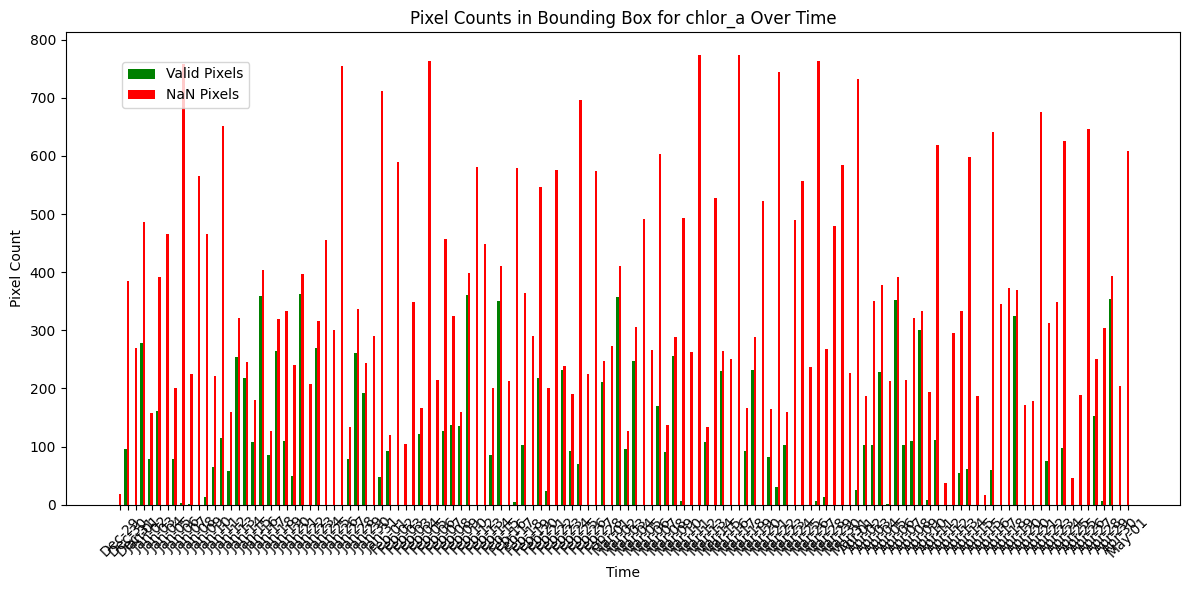

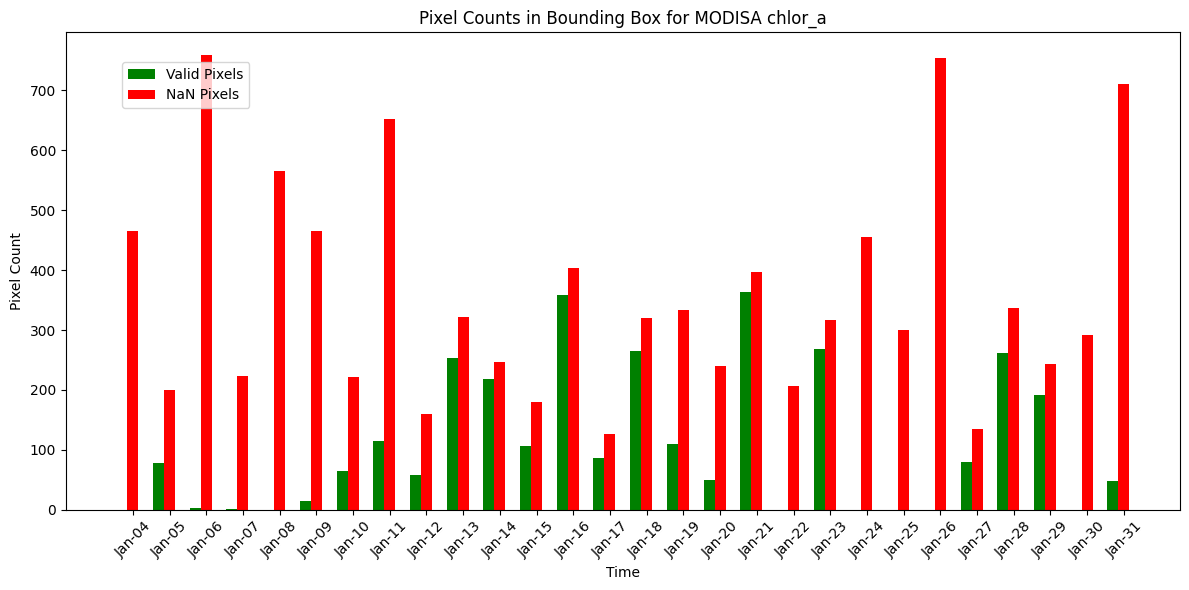

In [7]:
plot_pixel_counts(modisa_summary)
plot_pixel_counts(modisa_summary, start_date="2025-01-04", end_date="2025-02-01", title="Pixel Counts in Bounding Box for MODISA chlor_a")

Skipping file PACE_OCI.20250302T205129.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250302T205129.L2.OC_BGC.V3_0.NRT.nc'
Skipping file PACE_OCI.20250309T200459.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250309T200459.L2.OC_BGC.V3_0.NRT.nc'
Skipping file PACE_OCI.20250310T204032.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250310T204032.L2.OC_BGC.V3_0.NRT.nc'
Skipping file PACE_OCI.20250311T193741.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\\OneDrive\\Desktop\\pace-wildlife\\data\\PACE_OCI_L2_BGC_NRT\\PACE_OCI.20250311T193741.L2.OC_BGC.V3_0.NRT.nc'
Skipping file PACE_OCI.20250312T201313.L2.OC_BGC.V3_0.NRT.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\katel\

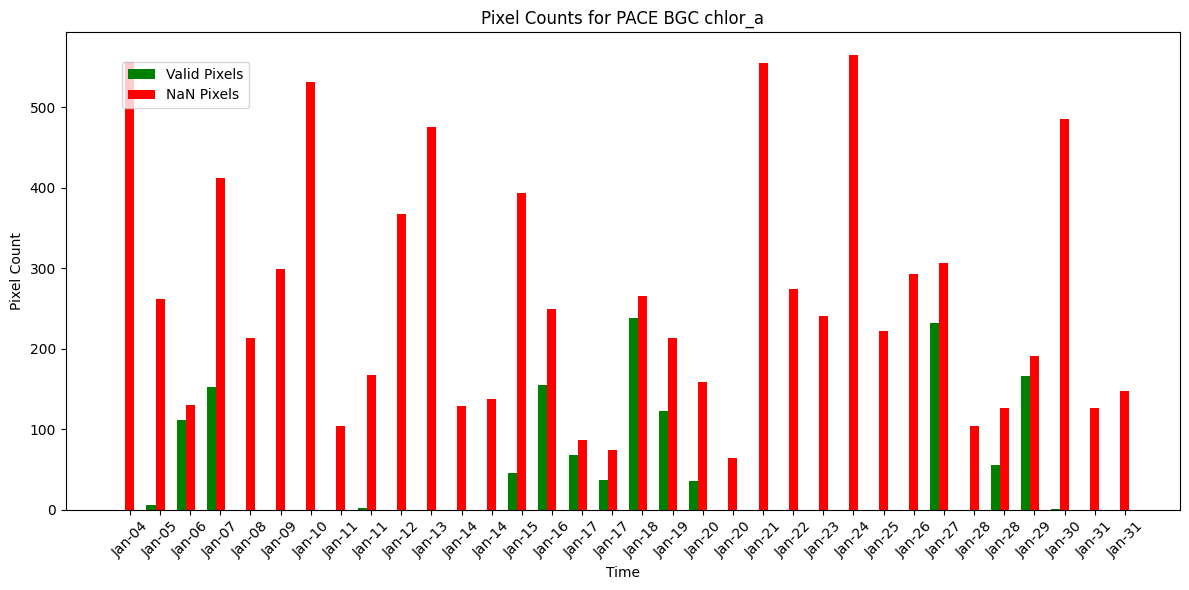

In [8]:
## Compared to PACE BGC (chlor_a data)
bgc_merged_ds = load_merged_dataset(bgc_dir, ['chlor_a'])

bgc_summary = summarize_variables_in_bbox(bgc_merged_ds, ["chlor_a"], pacific_pal_bbox)

plot_pixel_counts(bgc_summary, end_date="2025-02-01", title="Pixel Counts for PACE BGC chlor_a")

It seems that the chlorophyll-a concentration from MODIS has slightly less missing data for the month of January. 

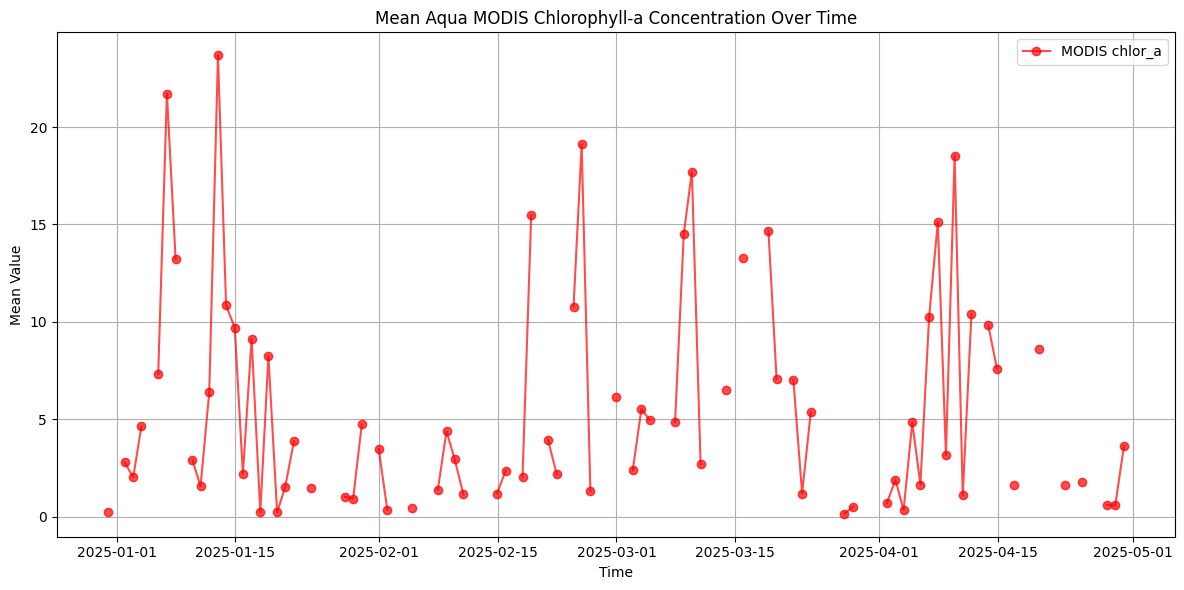

In [9]:
plt.figure(figsize=(12, 6))

df_modisa = pd.DataFrame(modisa_summary['chlor_a'])
df_modisa['time'] = pd.to_datetime(df_modisa['time'])
plt.plot(df_modisa['time'], df_modisa['mean_value'], label='MODIS chlor_a', color='red', marker='o', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.title("Mean Aqua MODIS Chlorophyll-a Concentration Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MODIS chlorophyll-a concentrations also have a fair amount of days with missing data, so it's hard to see a clear trend, but it seems that there are lower levels from around January 20th to February 15th. 

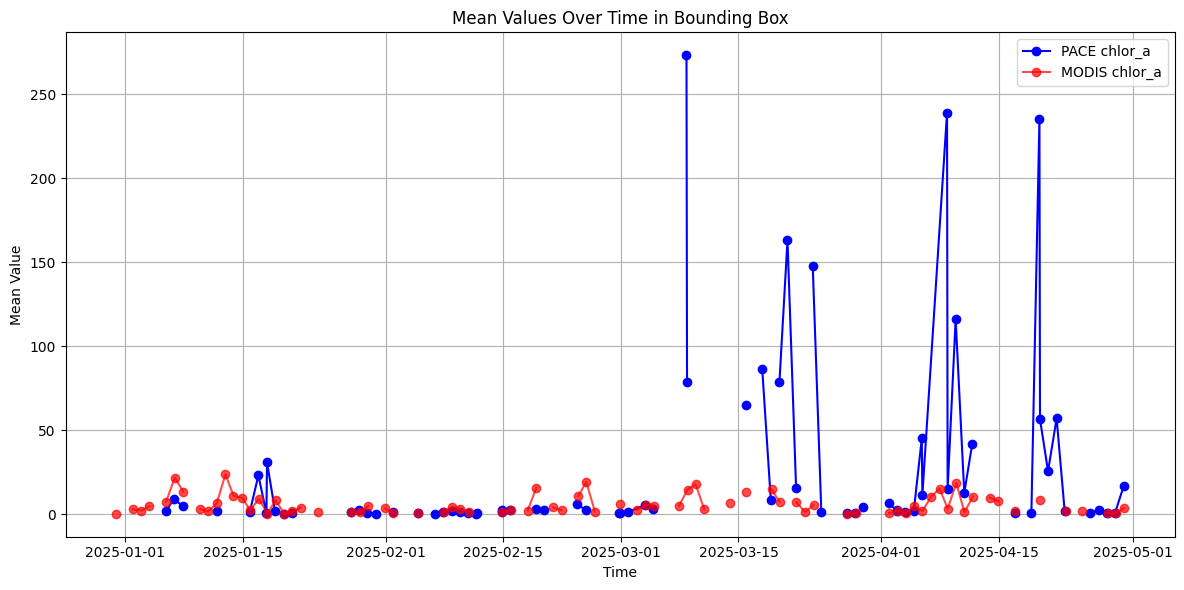

In [10]:
plt.figure(figsize=(12, 6))

df_bgc = pd.DataFrame(bgc_summary['chlor_a'])
df_bgc['time'] = pd.to_datetime(df_bgc['time'])
plt.plot(df_bgc['time'], df_bgc['mean_value'], label='PACE chlor_a', color='blue', marker='o')

df_modisa = pd.DataFrame(modisa_summary['chlor_a'])
df_modisa['time'] = pd.to_datetime(df_modisa['time'])
plt.plot(df_modisa['time'], df_modisa['mean_value'], label='MODIS chlor_a', color='red', marker='o', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.title("Mean Values Over Time in Bounding Box")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MODIS has less days with missing data at the beginning (January), but they both have missing data throughout. In March-May, PACE has much higher measurements of chlorophyll-a concentrations than the MODIS data. 

In [11]:
def apply_transformations(ds, transformations):
    """
    Apply specified transformations to variables in an xarray.Dataset.

    Parameters:
        ds (xarray.Dataset): The dataset to transform.
        transformations (dict): A mapping from variable names to transformation functions.

    Returns:
        xarray.Dataset: A new dataset with transformations applied.
    """
    ds_transformed = ds.copy()
    
    for var_name, func in transformations.items():
        if var_name in ds:
            try:
                ds_transformed[var_name] = func(ds[var_name])
            except Exception as e:
                print(f"Error applying transformation to {var_name}: {e}")
        else:
            print(f"Variable '{var_name}' not found in dataset.")
    
    return ds_transformed

bgc_merged_ds = apply_transformations(bgc_merged_ds, {"chlor_a": np.log})
modisa_merged_ds = apply_transformations(modisa_merged_ds, {"chlor_a": np.log})


In [12]:
transformed_bgc_summaries = summarize_variables_in_bbox(bgc_merged_ds, ["chlor_a"], pacific_pal_bbox)
transformed_modisa_summaries = summarize_variables_in_bbox(modisa_merged_ds, ["chlor_a"], pacific_pal_bbox)


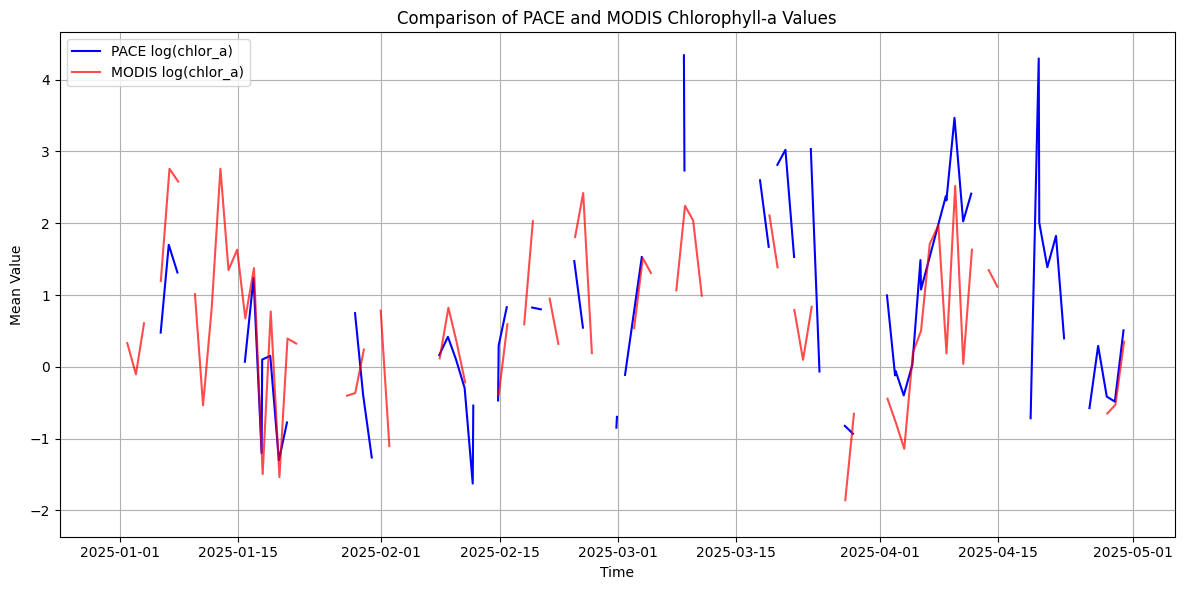

In [13]:
# log transformed plot

plt.figure(figsize=(12, 6))

df_bgc = pd.DataFrame(transformed_bgc_summaries['chlor_a'])
df_bgc['time'] = pd.to_datetime(df_bgc['time'])
plt.plot(df_bgc['time'], df_bgc['mean_value'], label='PACE log(chlor_a)', color='blue')

df_modisa = pd.DataFrame(transformed_modisa_summaries['chlor_a'])
df_modisa['time'] = pd.to_datetime(df_modisa['time'])
plt.plot(df_modisa['time'], df_modisa['mean_value'], label='MODIS log(chlor_a)', color='red', alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.title("Comparison of PACE and MODIS Chlorophyll-a Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Plotting the log-transformed chlorophyll-a concentrations, the measurements between the satellites look more similar, though they definitely do not match up completely. There are some dates where MODIS has measurements and PACE does not or vice versa. 

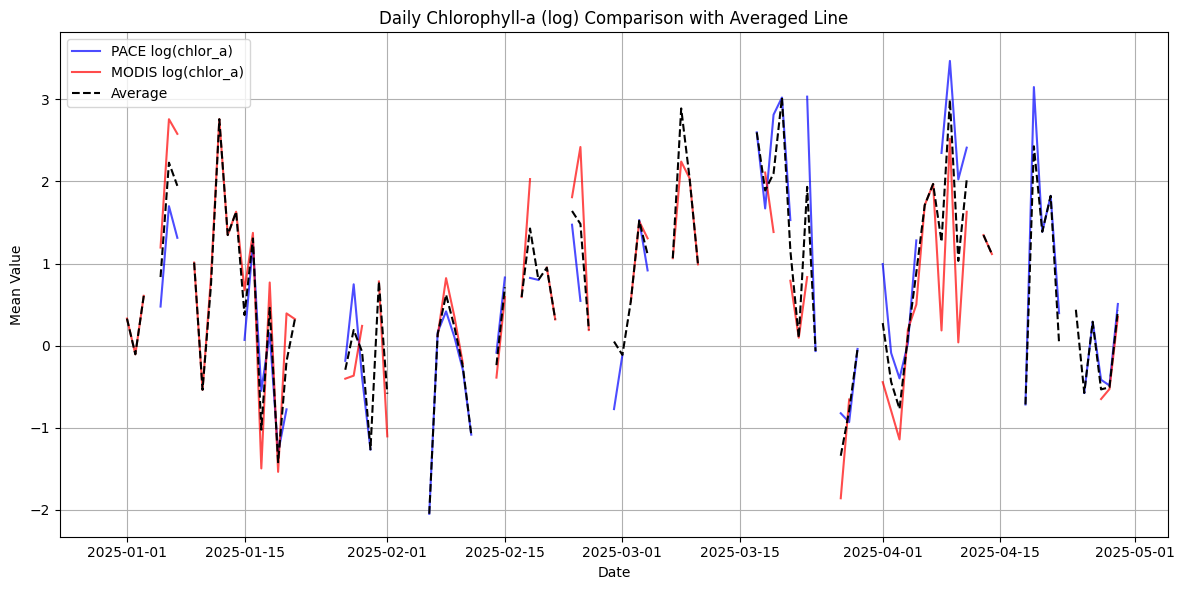

In [68]:
df_bgc['date'] = pd.to_datetime(df_bgc['time']).dt.date
df_modisa['date'] = pd.to_datetime(df_modisa['time']).dt.date

df_bgc_daily = df_bgc.groupby('date')['mean_value'].mean().reset_index().rename(columns={'mean_value': 'PACE'})
df_modisa_daily = df_modisa.groupby('date')['mean_value'].mean().reset_index().rename(columns={'mean_value': 'MODIS'})

df_merged = pd.merge(df_bgc_daily, df_modisa_daily, on='date', how='outer')

df_merged['Average'] = df_merged[['PACE', 'MODIS']].mean(axis=1, skipna=True)


df_merged['date'] = pd.to_datetime(df_merged['date'])  # make sure it's datetime for plotting
df_merged = df_merged.sort_values('date')

plt.figure(figsize=(12, 6))
plt.plot(df_merged['date'], df_merged['PACE'], label='PACE log(chlor_a)', color='blue', alpha=0.7)
plt.plot(df_merged['date'], df_merged['MODIS'], label='MODIS log(chlor_a)', color='red', alpha=0.7)
plt.plot(df_merged['date'], df_merged['Average'], label='Average', color='black', linestyle='--')

plt.xlabel("Date")
plt.ylabel("Mean Value")
plt.title("Daily Chlorophyll-a (log) Comparison with Averaged Line")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

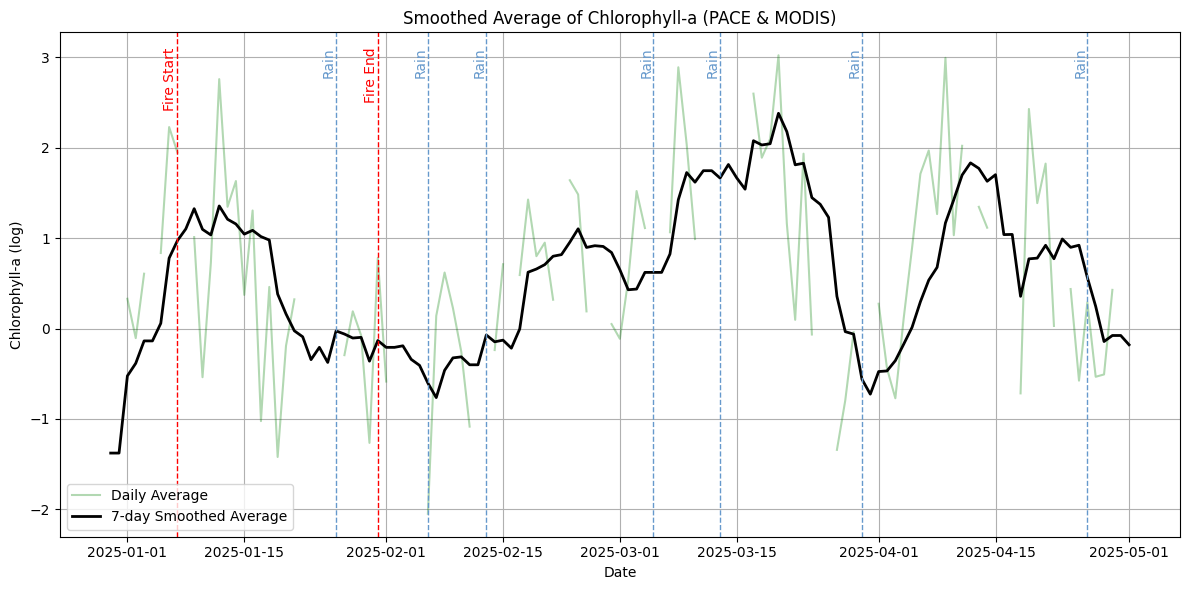

In [70]:
df_merged['Smoothed Avg'] = df_merged['Average'].rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_merged['date'], df_merged['Average'], label='Daily Average', color='green', alpha=0.3)
plt.plot(df_merged['date'], df_merged['Smoothed Avg'], label='7-day Smoothed Average', color='black', linewidth=2)

fire_start = pd.to_datetime("2025-01-07")
plt.axvline(x=fire_start, color='red', linestyle='--', linewidth=1)
plt.text(fire_start, plt.ylim()[1]*0.95, 'Fire Start', color='red', rotation=90, ha='right', va='top')

fire_end = pd.to_datetime("2025-01-31")
plt.axvline(x=fire_end, color='red', linestyle='--', linewidth=1)
plt.text(fire_end, plt.ylim()[1]*0.95, 'Fire End', color='red', rotation=90, ha='right', va='top')

# Key rain dates
key_rain_dates = ["2025-01-26", "2025-02-06", "2025-02-13", "2025-03-05", "2025-03-13", "2025-03-30", "2025-04-26"]
for date in key_rain_dates:
    rain_date = pd.to_datetime(date)
    plt.axvline(x=rain_date, color='#6699cc', linestyle='--', linewidth=1)
    plt.text(rain_date, plt.ylim()[1]*0.95, 'Rain', color='#6699cc', rotation=90, ha='right', va='top')


plt.xlabel("Date")
plt.ylabel("Chlorophyll-a (log)")
plt.title("Smoothed Average of Chlorophyll-a (PACE & MODIS)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Looking at the general trend of the chlorophyll-a concentration with data from two satellites and on a log-scale, it seems that there was a peak in concentration from near when the fire started that slowly declined over the next several weeks. This may be due to smoke or haze blocking sunlight and decreasing the rate of photosynthesis. Additionally, there were a few key dates with rain starting January 26th and a few times in Febrary and March. It seems that there tend to be increases in chlorophyll-a concentration following rain dates, possibly due to runoff flowing into the ocean and providing fire related nutrients such as nitrogen that fuel phytoplankton growth.

#### Land Vegetation Indices

In [ ]:
landvi_merged_ds = load_merged_dataset(landvi_dir, ["ndvi", "evi", "ndii", "ndwi"])

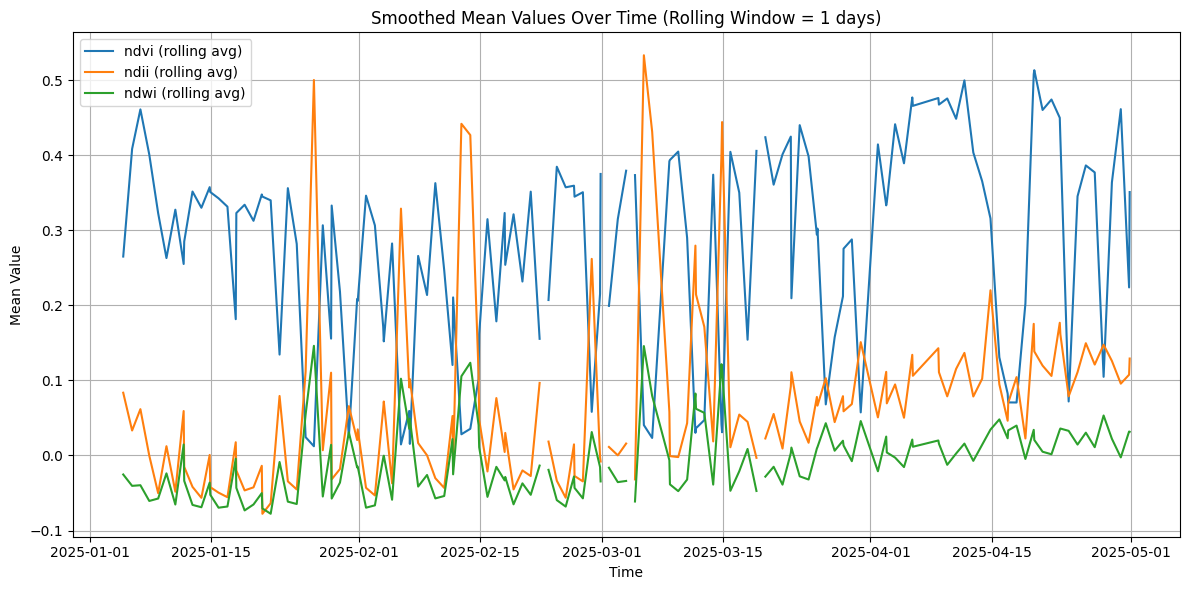

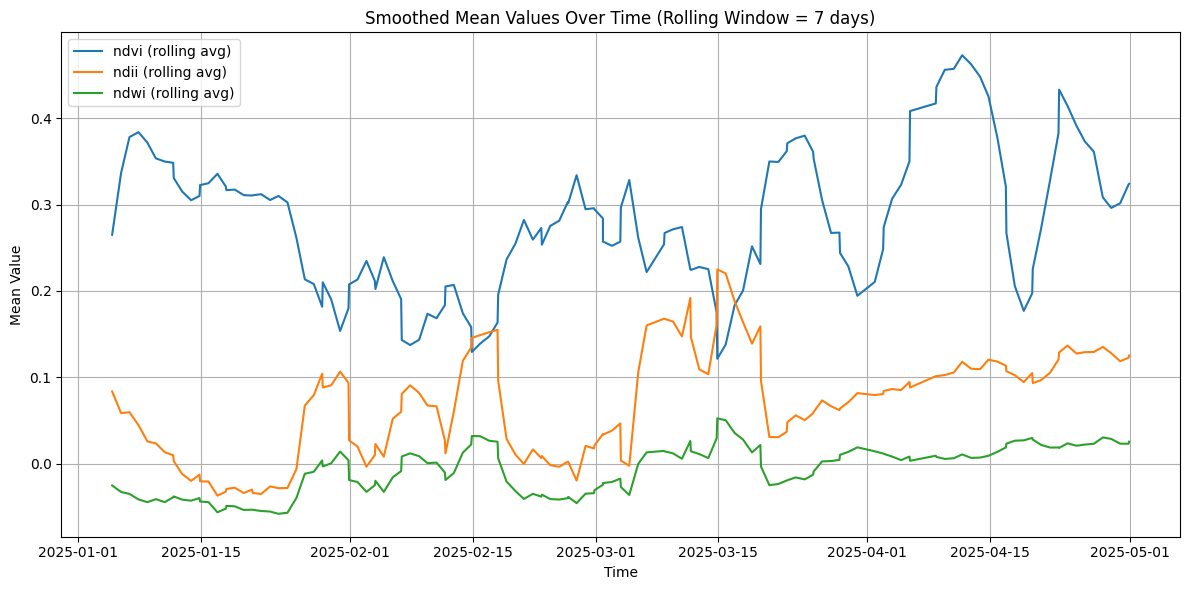

In [59]:
def plot_mean_values(summaries, window=7, mark_dates=False):
    plt.figure(figsize=(12, 6))

    for var_name, records in summaries.items():
        df = pd.DataFrame(records)
        df['time'] = pd.to_datetime(df['time'])

        # Sort and apply rolling mean
        df = df.sort_values('time')
        df['smoothed'] = df['mean_value'].rolling(window=window, min_periods=1).mean()

        plt.plot(df['time'], df['smoothed'], label=f"{var_name} (rolling avg)", linewidth=1.5)

    if mark_dates:
        fire_start = pd.to_datetime("2025-01-07")
        plt.axvline(x=fire_start, color='red', linestyle='--', linewidth=1)
        plt.text(fire_start, plt.ylim()[1]*0.95, 'Fire Start', color='red', rotation=90, ha='right', va='top')

        fire_end = pd.to_datetime("2025-01-31")
        plt.axvline(x=fire_end, color='red', linestyle='--', linewidth=1)
        plt.text(fire_end, plt.ylim()[1]*0.95, 'Fire End', color='red', rotation=90, ha='right', va='top')

        for start, end in rain_blocks:
            plt.axvspan(start, end + pd.Timedelta(days=1), color='#6699cc', alpha=0.3)
            rain_patch = mpatches.Patch(color='#6699cc', alpha=0.3, label='Rain')

    plt.xlabel("Time")
    plt.ylabel("Mean Value")
    plt.title(f"Smoothed Mean Values Over Time (Rolling Window = {window} days)")
    plt.legend()
    if mark_dates:
        plt.legend(handles=[rain_patch] + plt.gca().get_legend_handles_labels()[0]) 
    plt.grid(True)
    plt.tight_layout()
    plt.show()

landvi_summaries = summarize_variables_in_bbox(landvi_merged_ds, ["ndvi", "ndii", "ndwi"], pacific_pal_bbox)
plot_mean_values(landvi_summaries, window=1)
plot_mean_values(landvi_summaries)

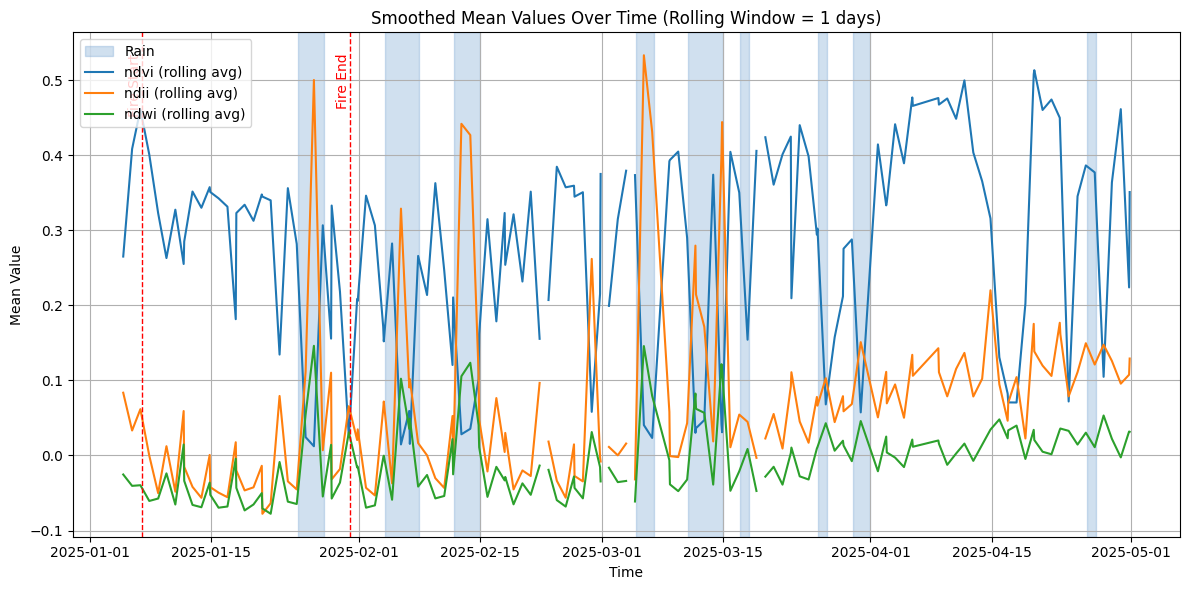

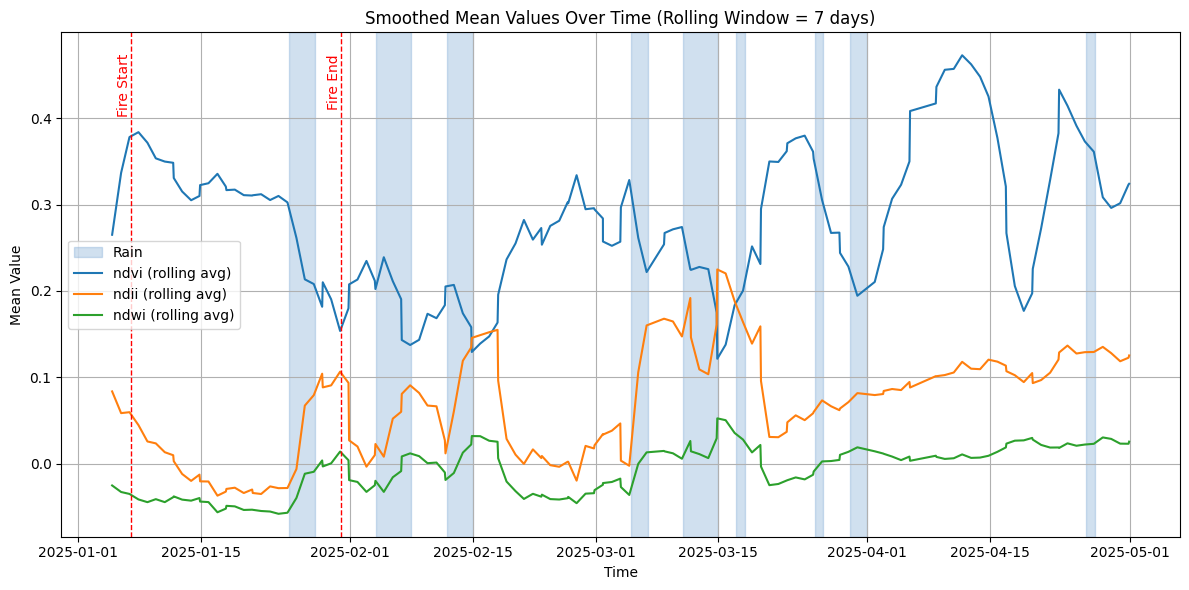

In [57]:
plot_mean_values(landvi_summaries, window=1, mark_dates=True)
plot_mean_values(landvi_summaries, mark_dates=True)


#### Aeorosol data and Chlorophyll concentrations

In [75]:
df_pm25 = pd.read_csv('../data/LA_PM25_2025.csv')
df_pm25 = df_pm25[df_pm25["Local Site Name"] == "Los Angeles-North Main Street"]
df_pm25 = df_pm25[["Date", "Daily Mean PM2.5 Concentration"]]
df_pm25.rename(columns={"Daily Mean PM2.5 Concentration": "PM2.5 (µg/m³)"}, inplace=True)

# Convert Date to datetime format for sorting and analysis
df_pm25["date"] = pd.to_datetime(df_pm25["Date"])
df_pm25.drop(columns=["Date"], inplace=True)

df_pm25.sort_values("date", inplace=True)

# Optional: Reset index
df_pm25.reset_index(drop=True, inplace=True)

start_date = "2025-01-01"
end_date = "2025-05-01"
df_pm25 = df_pm25[(df_pm25["date"] >= start_date) & (df_pm25["date"] <= end_date)]

# Show result
print(df_pm25.head())

   PM2.5 (µg/m³)       date
0           32.7 2025-01-01
1           20.5 2025-01-02
2           25.6 2025-01-03
3           29.9 2025-01-04
4           12.7 2025-01-05


In [77]:
df_chlor_pm = pd.merge(df_merged[['date', 'Smoothed Avg']], df_pm25, on='date', how='inner')
df_chlor_pm


,date,Smoothed Avg,PM2.5 (µg/m³)
0,2025-01-01,-0.523899,32.7
1,2025-01-02,-0.384497,20.5
2,2025-01-03,-0.136672,25.6
3,2025-01-04,-0.136672,29.9
4,2025-01-05,0.057812,12.7
...,...,...,...
106,2025-04-27,0.245341,5.1
107,2025-04-28,-0.143368,9.7
108,2025-04-29,-0.076812,11.9
109,2025-04-30,-0.076812,13.5


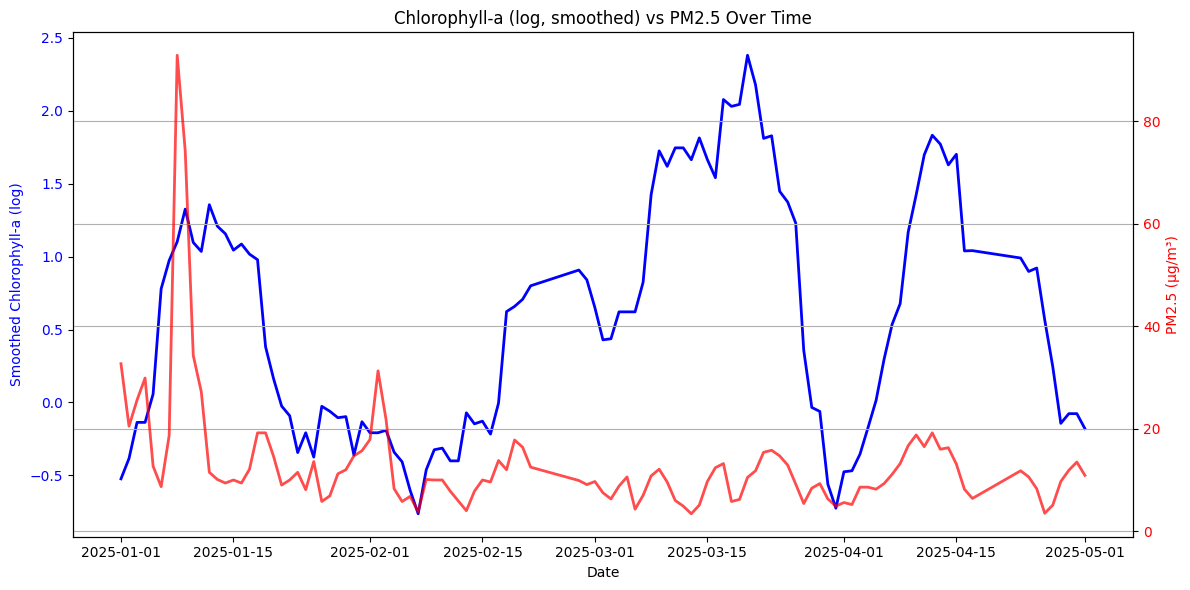

In [ ]:
# plot both PM2.5 data and chlorophyll 7 day average on the same plot
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Smoothed Chlorophyll-a on left y-axis
ax1.plot(df_chlor_pm['date'], df_chlor_pm['Smoothed Avg'], color='blue', label='Smoothed Chlorophyll-a (log)', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Smoothed Chlorophyll-a (log)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot PM2.5 on right y-axis
ax2.plot(df_chlor_pm['date'], df_chlor_pm['PM2.5 (µg/m³)'], color='red', label='PM2.5 (µg/m³)', linewidth=2, alpha=0.7)
ax2.set_ylabel('PM2.5 (µg/m³)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title("Chlorophyll-a (log, smoothed) vs PM2.5 Over Time")
fig.tight_layout()
plt.grid(True)

plt.show()

In [107]:
# time series connected scatter plot

def plot_connected_scatter_df(df, var_x, var_y, time_col='date', title=None, start_time=None, end_time=None,
                              fire_dates=None, rain_dates=None, cmap='viridis'):
    # Ensure datetime and filter
    df[time_col] = pd.to_datetime(df[time_col])
    if start_time:
        df = df[df[time_col] >= pd.to_datetime(start_time)]
    if end_time:
        df = df[df[time_col] <= pd.to_datetime(end_time)]
    
    # Drop rows with missing data
    df = df.dropna(subset=[var_x, var_y])

    x = df[var_x].values
    y = df[var_y].values
    times = mdates.date2num(df[time_col])  # For color mapping

    # Create line segments
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create line collection
    norm = plt.Normalize(times.min(), times.max())
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(times)
    lc.set_linewidth(2)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.add_collection(lc)
    ax.scatter(x, y, color='black', s=20, zorder=3)

    # Direction arrows
    for i in range(1, len(x)):
        ax.annotate('', xy=(x[i], y[i]), xytext=(x[i-1], y[i-1]),
                    arrowprops=dict(arrowstyle='-|>', color='gray', lw=1))

        # Mid-segment arrows
        x_mid = (x[i-1] + x[i]) / 2
        y_mid = (y[i-1] + y[i]) / 2
        dx = x[i] - x[i-1]
        dy = y[i] - y[i-1]
        ax.annotate('', xy=(x_mid + 0.0001 * dx, y_mid + 0.0001 * dy), xytext=(x_mid, y_mid),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=1.2))

    # Label with dates
    for i, row in df.iterrows():
        ax.annotate(row[time_col].strftime('%b-%d'), (row[var_x], row[var_y]),
                    textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
        
    if fire_dates:
        fire_dates = pd.to_datetime(fire_dates)
        fire_points = df[df[time_col].isin(fire_dates)]
        ax.scatter(fire_points[var_x], fire_points[var_y], color='red', label='Fire Date', s=60, zorder=2)
        
    if rain_dates:
        rain_dates = pd.to_datetime(rain_dates)
        rain_points = df[df[time_col].isin(rain_dates)]
        ax.scatter(rain_points[var_x], rain_points[var_y], color='blue', label='Rain Date', s=60, zorder=2)

    ax.set_xlabel(var_x)
    ax.set_ylabel(var_y)
    ax.set_title(title or f"Connected Scatterplot of {var_x} vs {var_y} Over Time")
    ax.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

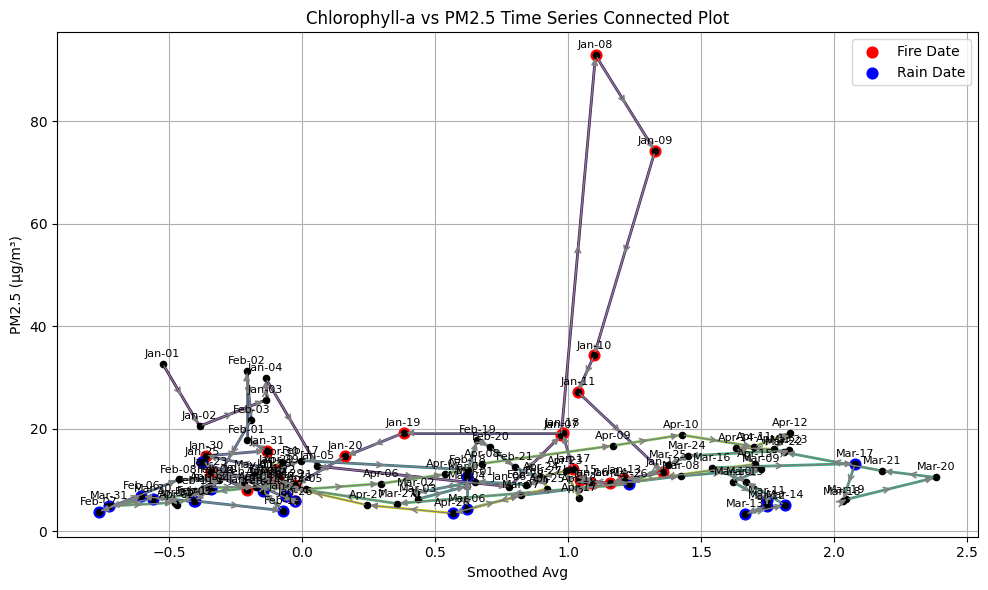

In [108]:
fire_dates = pd.date_range(start="2025-01-07", end="2025-01-31")
fire_dates = fire_dates.strftime('%Y-%m-%d').tolist()

plot_connected_scatter_df(
    df_chlor_pm,
    var_x='Smoothed Avg',
    var_y='PM2.5 (µg/m³)',
    time_col='date',
    title='Chlorophyll-a vs PM2.5 Time Series Connected Plot', 
    fire_dates=fire_dates,
    rain_dates=rain_dates, 
)

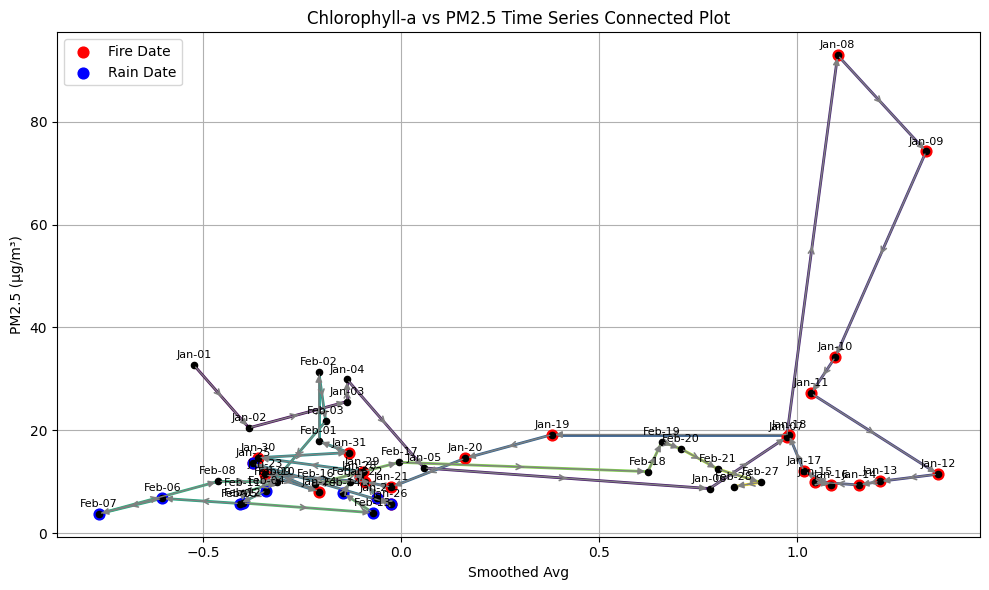

In [109]:
plot_connected_scatter_df(
    df_chlor_pm,
    var_x='Smoothed Avg',
    var_y='PM2.5 (µg/m³)',
    time_col='date',
    title='Chlorophyll-a vs PM2.5 Time Series Connected Plot', 
    fire_dates=fire_dates,
    rain_dates=rain_dates,
    end_time="2025-02-28"
)

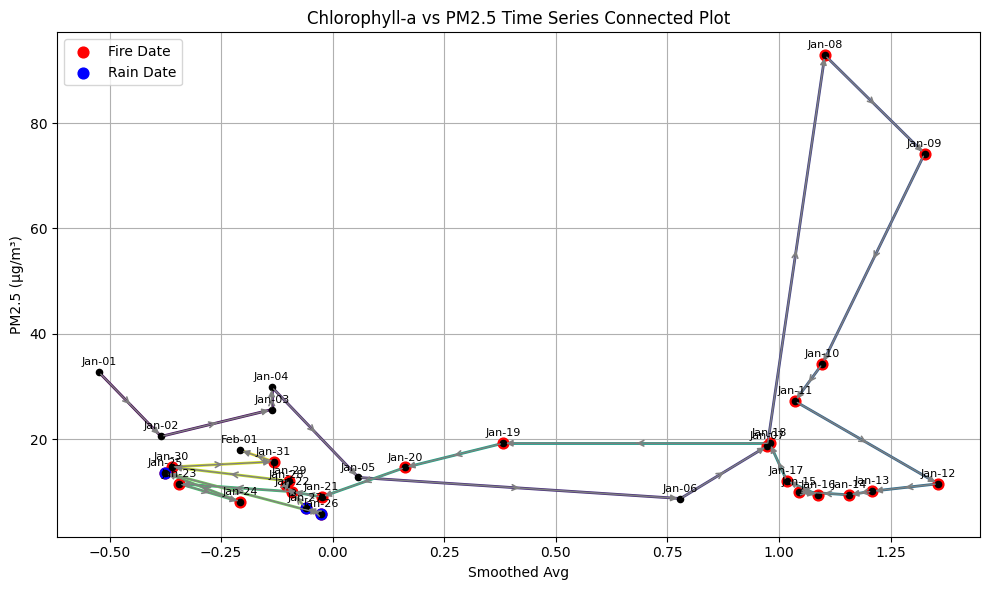

In [ ]:
plot_connected_scatter_df(
    df_chlor_pm,
    var_x='Smoothed Avg',
    var_y='PM2.5 (µg/m³)',
    time_col='date',
    title='Chlorophyll-a vs PM2.5 Time Series Connected Plot (January)', 
    fire_dates=fire_dates,
    rain_dates=rain_dates,
    end_time="2025-02-01"
)

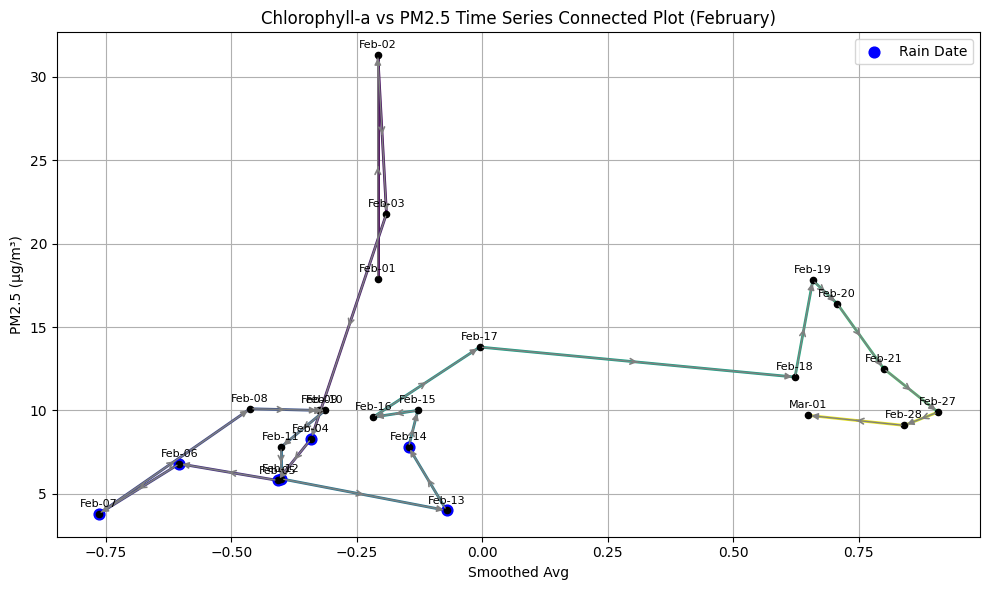

In [113]:
plot_connected_scatter_df(
    df_chlor_pm,
    var_x='Smoothed Avg',
    var_y='PM2.5 (µg/m³)',
    time_col='date',
    title='Chlorophyll-a vs PM2.5 Time Series Connected Plot (February)', 
    # fire_dates=fire_dates,
    rain_dates=rain_dates,
    start_time="2025-02-01",
    end_time="2025-03-01"
)

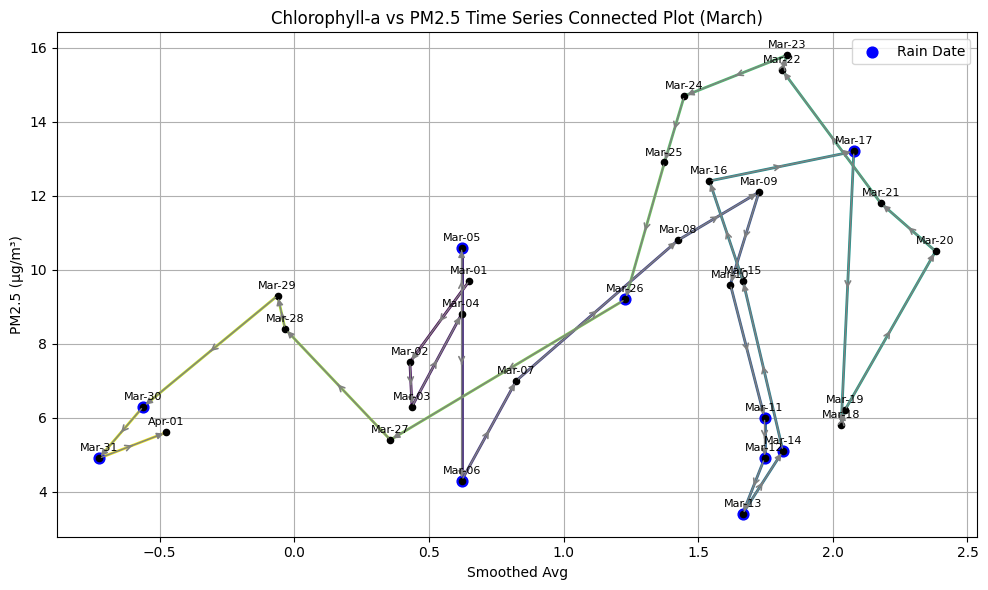

In [114]:
plot_connected_scatter_df(
    df_chlor_pm,
    var_x='Smoothed Avg',
    var_y='PM2.5 (µg/m³)',
    time_col='date',
    title='Chlorophyll-a vs PM2.5 Time Series Connected Plot (March)', 
    # fire_dates=fire_dates,
    rain_dates=rain_dates,
    start_time="2025-03-01",
    end_time="2025-04-01"
)